In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

import tqdm

import pandas as pd
from matplotlib.colors import LogNorm
from scipy import spatial,interpolate

import healpy as hp

## Import scanning law and compute some useful transformations

In [2]:
path_scanning_law = 'path/scanning/law'
_data = pd.read_csv(path_scanning_law)
_columns = ['JulianDayNumberRefEpoch2010TCB@Gaia',
       'JulianDayNumberRefEpoch2010TCB@Barycentre_1',
       'JulianDayNumberRefEpoch2010TCB@Barycentre_2', 'ra_FOV_1(deg)',
       'dec_FOV_1(deg)', 'scanPositionAngle_FOV_1(deg)', 'ra_FOV_2(deg)',
       'dec_FOV_2(deg)', 'scanPositionAngle_FOV_2(deg)']
_keys = ['tcb_at_gaia','tcb_at_bary1','tcb_at_bary2','ra_fov_1','dec_fov_1','angle_fov_1','ra_fov_2','dec_fov_2','angle_fov_2']
fox = {}
for j,k in zip(_columns,_keys):
    fox[k] = _data[j].values
    
xyz_fov_1 = np.stack([np.cos(np.deg2rad(fox['ra_fov_1']))*np.cos(np.deg2rad(fox['dec_fov_1'])),
                      np.sin(np.deg2rad(fox['ra_fov_1']))*np.cos(np.deg2rad(fox['dec_fov_1'])),
                      np.sin(np.deg2rad(fox['dec_fov_1']))]).T
xyz_fov_2 = np.stack([np.cos(np.deg2rad(fox['ra_fov_2']))*np.cos(np.deg2rad(fox['dec_fov_2'])),
                      np.sin(np.deg2rad(fox['ra_fov_2']))*np.cos(np.deg2rad(fox['dec_fov_2'])),
                      np.sin(np.deg2rad(fox['dec_fov_2']))]).T
print('Loaded scanning law.')

##### Compute rotation matrices
_xaxis = 0.5*(xyz_fov_1+xyz_fov_2)
_zaxis = np.cross(xyz_fov_1,xyz_fov_2)
_yaxis = -np.cross(_xaxis,_zaxis)
_xaxis /= np.linalg.norm(_xaxis,axis=1)[:,np.newaxis]
_yaxis /= np.linalg.norm(_yaxis,axis=1)[:,np.newaxis]
_zaxis /= np.linalg.norm(_zaxis,axis=1)[:,np.newaxis]

_uaxis = np.array([1,0,0])
_vaxis = np.array([0,1,0])
_waxis = np.array([0,0,1])

_matrix = np.moveaxis(np.stack([np.dot(_xaxis,_uaxis),np.dot(_xaxis,_vaxis),np.dot(_xaxis,_waxis),
          np.dot(_yaxis,_uaxis),np.dot(_yaxis,_vaxis),np.dot(_yaxis,_waxis),
          np.dot(_zaxis,_uaxis),np.dot(_zaxis,_vaxis),np.dot(_zaxis,_waxis)]).reshape((3,3,_xaxis.shape[0])),2,0)

print('Computed rotation matrix.')

Loaded scanning law.
Computed rotation matrix.


## Download from the Gaia archive the epoch data for the DR2 variable stars

In [3]:
from astroquery.gaia import Gaia

user_Gaia = 'user'
pass_Gaia = 'password'

# Try to download all transit times for phometric epoch data for variables
Gaia.MAIN_GAIA_TABLE = "gaiadr2.gaia_source"
Gaia.login(user=user_Gaia, password=pass_Gaia)
job = Gaia.launch_job_async("select * from gaiadr2.gaia_source where phot_variable_flag='VARIABLE'")
r = job.get_results().to_pandas()

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
INFO: Query finished. [astroquery.utils.tap.core]


In [4]:
# if already downloaded, load here

columns_box = ['source_id','times_observation','transit_id','magnitudes_observation','fluxes','flux_errors',\
              'rejections_photometry','rejections_variability','other_flags']
_box = np.load('../epoch_data.txt.npy',allow_pickle = True)

In [5]:
sid_coord = []
ra_arr = np.array([])
dec_arr = np.array([])
for i in tqdm.tqdm_notebook(range(len(_box[:,0]))):
    s_id = _box[i,0]
    ra = r.query('source_id == @s_id')['ra'].min()
    dec = r.query('source_id == @s_id')['dec'].min()
    sid_coord.append(s_id)
    ra_arr = np.append(ra_arr,ra)
    dec_arr = np.append(dec_arr,dec)
#print(_box[i].shape)

In [6]:
# Get predicted observation times from ra,dec of each source

radec_source = np.stack([ra_arr,dec_arr]).T
print(radec_source.shape)
N_source = radec_source.shape[0]

##### Compute tree
xyz_source = np.stack([np.cos(np.deg2rad(radec_source[:,0]))*np.cos(np.deg2rad(radec_source[:,1])),
              np.sin(np.deg2rad(radec_source[:,0]))*np.cos(np.deg2rad(radec_source[:,1])),
              np.sin(np.deg2rad(radec_source[:,1]))]).T
from scipy import spatial
tree_source = spatial.cKDTree(xyz_source)

from scipy import interpolate

# Define units
speed_of_light_AU_per_day = 299792458.0*(86400.0/149597870.700/1e3)

# Prepare ephem data
ephem_dat = 'path_to_data' #load from the scanninglaw package in https://github.com/gaiaverse/selectionfunctions
gaia_ephem_data = pd.read_csv(ephem_dat,skiprows=64)
gaia_ephem_box = {k:gaia_ephem_data[k].values for k in ['JDTDB','X','Y','Z','VX','VY','VZ']}
gaia_ephem_velocity = interpolate.interp1d(gaia_ephem_box['JDTDB']-2455197.5,np.stack([gaia_ephem_box['VX'],gaia_ephem_box['VY'],gaia_ephem_box['VZ']])/speed_of_light_AU_per_day,kind='cubic')


##### Find intersections
n_source = np.zeros(N_source)
t_previous = -99999*np.ones(N_source)

t_box = {i:[] for i in range(N_source)}
t_diff = 1.0/24 # 1 hours
r_search = np.tan(np.deg2rad((0.345+0.05)*np.sqrt(2)))
b_fov = 0.345

print('New offsets')
zeta_origin_1 = +220.997922127812/3600
zeta_origin_2 = -220.997922127812/3600

b_upp_1 = b_fov+zeta_origin_1
b_low_1 = -b_fov+zeta_origin_1
b_upp_2 = b_fov+zeta_origin_2
b_low_2 = -b_fov+zeta_origin_2

l_fov_1 = -106.5/2.0
l_fov_2 = +106.5/2.0

for _tidx in tqdm.tqdm_notebook(range(0,xyz_fov_1.shape[0])):
    _t_now = fox['tcb_at_gaia'][_tidx]
    _in_fov = tree_source.query_ball_point([xyz_fov_1[_tidx].copy(order='C'),xyz_fov_2[_tidx].copy(order='C')],r_search)
    _in_fov = _in_fov[0]+_in_fov[1]
    if len(_in_fov) == 0:
        continue
        
    # Aberration correction
    _gaia_velocity = gaia_ephem_velocity(_t_now)
    _xyz = xyz_source[_in_fov] + _gaia_velocity
    _xyz = _xyz/np.linalg.norm(_xyz,axis=1)[:,np.newaxis]
    
    _uvw = np.einsum('ij,nj->ni',_matrix[_tidx],_xyz)
    _l = np.rad2deg(np.arctan2(_uvw[:,1],_uvw[:,0]))
    _b = np.rad2deg(np.arctan2(_uvw[:,2],np.sqrt(_uvw[:,0]**2.0+_uvw[:,1]**2.0)))

    #_where = np.where((np.abs(_b)<b_fov)&(_t_now-t_previous[_in_fov]>t_diff))
    _where = np.where((((np.abs(_l-l_fov_1)<1.0)&(_b<b_upp_1)&(_b>b_low_1))|((np.abs(_l-l_fov_2)<1.0)&(_b<b_upp_2)&(_b>b_low_2)))&(_t_now-t_previous[_in_fov]>t_diff))
    _valid = np.array(_in_fov,dtype=np.int)[_where]

    n_source[_valid] += 1
    t_previous[_valid] = _t_now
    if len(_valid)>0:
        for _sidx in _valid:
            t_box[_sidx].append(_t_now)

(550737, 2)
New offsets


/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_3162/2182093779.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _tidx in tqdm.tqdm_notebook(range(0,xyz_fov_1.shape[0])):


  0%|          | 0/5771911 [00:00<?, ?it/s]

/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_3162/2182093779.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _valid = np.array(_in_fov,dtype=np.int)[_where]


In [15]:
# Match detections to predictions

success_threshold = 0.01
sox = {}
false_negative = 0
N_source = _box[:,0].size  # change when doing all the stars

for _idx in tqdm.tqdm_notebook(range(N_source)):
    sox[_idx] = {}
    _t_epochphotometry = _box[_idx,1] #np.array(box['time'][_idx])
    _t_predicted = np.array(t_box[_idx])
    _diff = np.abs(_t_epochphotometry[:,np.newaxis]-_t_predicted[np.newaxis,:])
    _min_index = np.argmin(_diff,axis=0)
    _criteria = _diff[_min_index,np.arange(_t_predicted.size)]
    _success = np.where(_criteria <= success_threshold)
    _failure = np.where(_criteria >  success_threshold)
    if _t_epochphotometry.size < _success[0].size:
        print(_idx)
        break
    false_negative += _t_epochphotometry.size - _success[0].size
    sox[_idx]['success_times'] = _t_predicted[_success]
    sox[_idx]['failure_times'] = _t_predicted[_failure]
    sox[_idx]['success_mag'] = _box[_idx,3][_min_index[_success]]
    sox[_idx]['success_mag_error'] = np.array((5.0/(2.0*np.log(10)))*_box[_idx,5]/_box[_idx,4])[_min_index[_success]] # box['g_mag_error'][_idx][_min_index[_success]]
    
print(false_negative)

/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_3162/2654744867.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _idx in tqdm.tqdm_notebook(range(N_source)):


  0%|          | 0/550737 [00:00<?, ?it/s]

43727


In [16]:
n_failure = np.array([sox[_idx]['failure_times'].size for _idx in tqdm.tqdm_notebook(range(N_source))])
n_success = np.array([sox[_idx]['success_times'].size for _idx in tqdm.tqdm_notebook(range(N_source))])

/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_3162/3307098735.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  n_failure = np.array([sox[_idx]['failure_times'].size for _idx in tqdm.tqdm_notebook(range(N_source))])


  0%|          | 0/550737 [00:00<?, ?it/s]

/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_3162/3307098735.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  n_success = np.array([sox[_idx]['success_times'].size for _idx in tqdm.tqdm_notebook(range(N_source))])


  0%|          | 0/550737 [00:00<?, ?it/s]

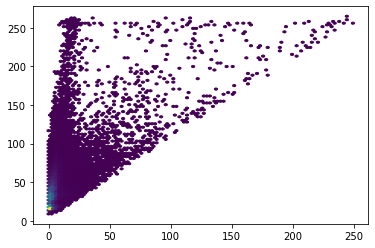

In [17]:
plt.hexbin(n_failure,n_success+n_failure,mincnt=1)

In [18]:
_bad = np.where(n_failure/(n_success+n_failure)>0.4)

0.0 180.0 -180.0 180.0


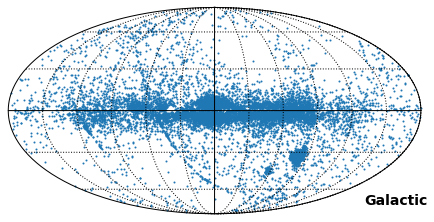

In [19]:
hp.graticule(coord=['G'])
hp.projscatter(ra_arr[_bad],dec_arr[_bad],lonlat=True,coord=['C','G'],s=1)

In [20]:
def GaussianProcess(time_s,mag_s,error_s,time_f):

    mean_mag = (mag_s/error_s).sum()/(1.0/error_s).sum()
    std_mag = np.std(mag_s)
    eps2 = std_mag**2.0
    l2 = 1.0

    cov_11 = eps2*np.exp(-(time_f[:,np.newaxis]-time_f[np.newaxis,:])**2.0/l2)
    cov_12 = eps2*np.exp(-(time_f[:,np.newaxis]-time_s[np.newaxis,:])**2.0/l2)
    cov_22 = eps2*np.exp(-(time_s[:,np.newaxis]-time_s[np.newaxis,:])**2.0/l2)+np.diag(error_s**2.0)
    cov_22_inv = np.linalg.pinv(cov_22)
    mag_f = mean_mag + np.dot(cov_12,np.dot(cov_22_inv,mag_s-mean_mag))
    cov_f = cov_11 - np.dot(cov_12,np.dot(cov_22_inv,cov_12.T))
    error_f = np.sqrt(np.diag(cov_f))
    
    return mag_f, error_f

for _idx in tqdm.tqdm_notebook(range(N_source)):
    if n_failure[_idx] > 0:
        try:
            sox[_idx]['failure_mag'], sox[_idx]['failure_mag_error'] = GaussianProcess(sox[_idx]['success_times'],sox[_idx]['success_mag'],sox[_idx]['success_mag_error'],sox[_idx]['failure_times'])
        except np.linalg.LinAlgError:
            print(_idx)
            break
            
    else:
        sox[_idx]['failure_mag'] = np.zeros(0)
        sox[_idx]['failure_mag_error'] = np.zeros(0)

/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_3162/2353852368.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _idx in tqdm.tqdm_notebook(range(N_source)):


  0%|          | 0/550737 [00:00<?, ?it/s]

<ErrorbarContainer object of 3 artists>

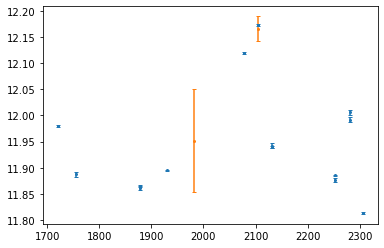

In [22]:
_idx = 315851
plt.errorbar(sox[_idx]['success_times'],sox[_idx]['success_mag'],yerr= sox[_idx]['success_mag_error'],ls='none',marker='o',capsize=2,ms=2)
plt.errorbar(sox[_idx]['failure_times'],sox[_idx]['failure_mag'],yerr= sox[_idx]['failure_mag_error'],ls='none',marker='o',capsize=2,ms=2)


-294.9417310898152


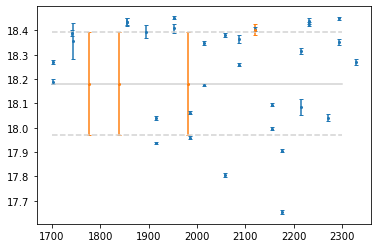

In [24]:
l2 = 1**2.0
_idx = 500000

time_f = sox[_idx]['failure_times']
time_s = sox[_idx]['success_times']
mag_s = sox[_idx]['success_mag']
error_s = sox[_idx]['success_mag_error']

mean_mag = (mag_s/error_s).sum()/(1.0/error_s).sum()
std_mag = np.std(mag_s)
eps2 = std_mag**2.0

cov_11 = eps2*np.exp(-(time_f[:,np.newaxis]-time_f[np.newaxis,:])**2.0/l2)
cov_12 = eps2*np.exp(-(time_f[:,np.newaxis]-time_s[np.newaxis,:])**2.0/l2)
cov_22 = eps2*np.exp(-(time_s[:,np.newaxis]-time_s[np.newaxis,:])**2.0/l2)+np.diag(error_s**2.0)
cov_22_inv = np.linalg.pinv(cov_22)
mag_f = mean_mag + np.dot(cov_12,np.dot(cov_22_inv,mag_s-mean_mag))
cov_f = cov_11 - np.dot(cov_12,np.dot(cov_22_inv,cov_12.T))
error_f = np.sqrt(np.diag(cov_f))

ll = -0.5*(np.dot((mag_s-mean_mag).T,np.dot(cov_22_inv,mag_s-mean_mag))+np.log(np.linalg.det(cov_22)))
print(ll)

plt.errorbar(sox[_idx]['success_times'],sox[_idx]['success_mag'],yerr= sox[_idx]['success_mag_error'],ls='none',marker='o',capsize=2,ms=2)
plt.errorbar(sox[_idx]['failure_times'],mag_f,yerr= error_f,ls='none',marker='o',capsize=2,ms=2)

plt.plot([1700,2300],[mean_mag,mean_mag],ls='-',c='lightgrey')
plt.plot([1700,2300],[mean_mag-std_mag,mean_mag-std_mag],ls='--',c='lightgrey')
plt.plot([1700,2300],[mean_mag+std_mag,mean_mag+std_mag],ls='--',c='lightgrey')

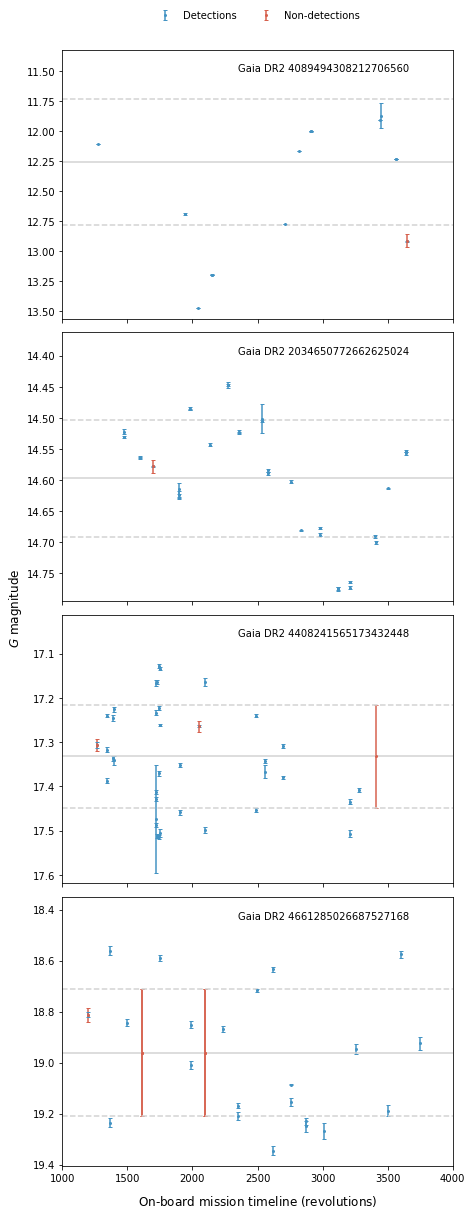

In [46]:
fig, axes = plt.subplots(4,1,figsize=(4,10),sharex=True)

def time_to_obmt(_time):
    return 1717.6256+((_time+2455197.5 - 2457023.5 - 0.25)*4)

l1,l2 = 0,0


for i,ax,_idx in zip(range(4),axes,[536340,256588,330005,462714]):
    del l1, l2
    mag_s = sox[_idx]['success_mag']
    error_s = sox[_idx]['success_mag_error']
    
    mean_mag = (mag_s/error_s).sum()/(1.0/error_s).sum()
    std_mag = np.std(mag_s)
    

    l1 = ax.errorbar(time_to_obmt(sox[_idx]['success_times']),sox[_idx]['success_mag'],yerr= sox[_idx]['success_mag_error'],ls='none',marker='o',capsize=2,ms=2,color=plt.cm.RdBu(0.8))
    l2 = ax.errorbar(time_to_obmt(sox[_idx]['failure_times']),sox[_idx]['failure_mag'],yerr= sox[_idx]['failure_mag_error'],ls='none',marker='o',capsize=2,ms=2,color=plt.cm.RdBu(0.2))

    ax.plot([1000,4000],[mean_mag,mean_mag],ls='-',c='lightgrey')
    ax.plot([1000,4000],[mean_mag-std_mag,mean_mag-std_mag],ls='--',c='lightgrey')
    ax.plot([1000,4000],[mean_mag+std_mag,mean_mag+std_mag],ls='--',c='lightgrey')
    y_lower,y_upper = ax.get_ylim()
    ax.set_ylim([y_lower-0.17*(y_upper-y_lower),y_upper])
    ax.invert_yaxis()
    ax.text(0.67, 0.93,'Gaia DR2 %i'%_box[_idx,0],
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)
axes[3].set_xlim([1000,4000])
plt.subplots_adjust(wspace=0, hspace=0.05)

fig.subplots_adjust(top=0.9, wspace=0.33)
fig.set_figheight(20)
fig.set_figwidth(7)

axes[0].legend(handles = [l1,l2] , labels=['Detections', 'Non-detections'],loc='upper center', 
             bbox_to_anchor=(0.5, 1.18),fancybox=False, frameon=False, shadow=False, ncol=2)


fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.xlabel('On-board mission timeline $(\mathrm{revolutions})$',labelpad = 10,fontsize=12)
plt.ylabel('$G$ magnitude',fontsize=12,labelpad=15)
#plt.savefig('./results/gaussian_process.pdf',bbox_inches='tight',dpi=300)
#plt.savefig('./results/gaussian_process.png',bbox_inches='tight',dpi=300)
plt.show()

In [55]:
if True:
    times = np.concatenate([np.concatenate([sox[_idx]['success_times'],sox[_idx]['failure_times']]) for _idx in tqdm.tqdm_notebook(range(N_source))])
    mags = np.concatenate([np.concatenate([sox[_idx]['success_mag'],sox[_idx]['failure_mag']]) for _idx in tqdm.tqdm_notebook(range(N_source))])
    errors = np.concatenate([np.concatenate([sox[_idx]['success_mag_error'],sox[_idx]['failure_mag_error']]) for _idx in tqdm.tqdm_notebook(range(N_source))])
    successes = np.concatenate([np.concatenate([np.ones(sox[_idx]['success_times'].size),np.zeros(sox[_idx]['failure_times'].size)]) for _idx in tqdm.tqdm_notebook(range(N_source))])

    sp_idx = np.searchsorted(sp_bins,mags,side='left')-1
    spox = {}
    for _idx in tqdm.tqdm_notebook(range(19)):
        sp_in = np.where((sp_idx == _idx))
        spox[_idx] = {}
        sp_sort = sp_in[0][np.argsort(times[sp_in])]
        spox[_idx]['times'] = times[sp_sort]
        spox[_idx]['mags'] = mags[sp_sort]
        spox[_idx]['errors'] = errors[sp_sort]
        spox[_idx]['successes'] = successes[sp_sort]
            
    with open('deletions_box_stage_3.p', 'wb') as fp:
        pickle.dump(spox,fp)
else:
    with open('deletions_box_stage_3.p', 'rb') as fp:
        spox = pickle.load(fp)

/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_3162/906851339.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  times = np.concatenate([np.concatenate([sox[_idx]['success_times'],sox[_idx]['failure_times']]) for _idx in tqdm.tqdm_notebook(range(N_source))])


  0%|          | 0/550737 [00:00<?, ?it/s]

/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_3162/906851339.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  mags = np.concatenate([np.concatenate([sox[_idx]['success_mag'],sox[_idx]['failure_mag']]) for _idx in tqdm.tqdm_notebook(range(N_source))])


  0%|          | 0/550737 [00:00<?, ?it/s]

/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_3162/906851339.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  errors = np.concatenate([np.concatenate([sox[_idx]['success_mag_error'],sox[_idx]['failure_mag_error']]) for _idx in tqdm.tqdm_notebook(range(N_source))])


  0%|          | 0/550737 [00:00<?, ?it/s]

/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_3162/906851339.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  successes = np.concatenate([np.concatenate([np.ones(sox[_idx]['success_times'].size),np.zeros(sox[_idx]['failure_times'].size)]) for _idx in tqdm.tqdm_notebook(range(N_source))])


  0%|          | 0/550737 [00:00<?, ?it/s]

/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_3162/906851339.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _idx in tqdm.tqdm_notebook(range(19)):


  0%|          | 0/19 [00:00<?, ?it/s]

/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_3162/3711283985.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _idx in tqdm.tqdm_notebook(range(19)):


  0%|          | 0/19 [00:00<?, ?it/s]

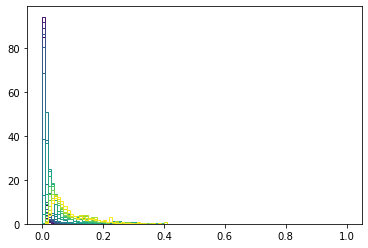

In [56]:
bins = np.arange(0,1.0+1e-3,1e-2)
for _idx in tqdm.tqdm_notebook(range(19)):
    plt.hist(spox[_idx]['errors'],bins,histtype='step',color=plt.cm.viridis(_idx/18),density=True);